In [32]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,f1_score
from autocluster.autohypothesis import autohypothesis_utils
import miceforest as mf


In [33]:
emploi_df = pd.read_csv('emploi_62.csv').drop(columns=["brsa_clep"])
#emploi_df = pd.read_csv('emploi_62.csv').drop(columns=["brsa_clep","age"])
emploi_df.rename(columns={"duree_rsa_annee": "target"}, inplace=True)

In [34]:
# Apply the function to the dataframe
emploi_df = autohypothesis_utils.split_responses(emploi_df, "Selon_vous__avez-vous_des_freins_à_l'emploi_?__plusieurs_réponses_possibles_")
emploi_df = autohypothesis_utils.split_responses(emploi_df, "Que_pensez-vous_de_votre_logement_?__plusieurs_réponses_possibles_")
emploi_df = autohypothesis_utils.split_responses(emploi_df, "Comment_vous_déplacez-vous__dans_votre_quotidien_?__plusieurs_réponses_possibles_")


In [35]:
df =emploi_df

In [36]:
category_mappings = {}

for column in df.columns:
    if df[column].dtype == 'object':
        # Convertir la colonne en type 'category' et enregistrer le mappage
        df[column] = df[column].astype('category')
        # Enregistre le mappage de la catégorie vers le code
        category_mappings[column] = dict(enumerate(df[column].cat.categories))
        # Encodage des catégories en entiers
        df[column] = df[column].cat.codes.replace(-1, np.nan)




In [37]:

# Create kernel. 
kds = mf.ImputationKernel(
  df,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 2 iterations
kds.mice(10)

# Return the completed dataset.
df_imputed = kds.complete_data()



In [38]:

for column in df_imputed.columns:
    if column in category_mappings:
        df_imputed[column] = df_imputed[column].map(category_mappings[column])

df_imputed

,Qui_gère_le_budget_à_la_maison_?,Comment_faites-vous_pour_gérer_votre_budget_?,Avez-vous_des_crédits_en_cours_?_,Avez-vous_des_difficultés_concernant_votre_budget_?,Y_a-t-il_des_éléments_que_vous_souhaiteriez_aborder_concernant_votre_budget_?,Exercez-vous_une_activité_professionnelle_?_,Recherchez-vous_un_emploi_?,Avez-vous_une_expérience_professionnelle_?,Quel_est_votre_parcours_de_formation__votre_niveau_de_diplôme_?,Etes-vous_à_l'aise_avec_l'outil_informatique_?,...,Mauvais état,Bruyant,Bon état général,Surpeuplé (dans le cas d'un hébergement),Co-voiturage,En voiture,En 2 roues,Accompagné,À pied,En transports en commun
0,Je gère mon budget,Je paie mes factures au fur et à mesure,False,Aucune difficulté,False,Non,False,True,Niveau 3 : CAP/BEP,Oui,...,False,False,True,False,False,True,False,False,False,False
1,Je gère mon budget,Je vis au jour le jour,False,Aucune difficulté,False,Non,False,True,CAP/BEP (non obtenu),"Non, je n'en ai pas besoin",...,False,False,True,False,False,False,False,False,True,False
2,Je gère mon budget,Je mets de l'argent de côté,False,Aucune difficulté,False,Non,False,False,CAP/BEP (non obtenu),Oui,...,False,False,True,False,False,False,False,False,True,True
3,Je gère mon budget,J'ai toujours du retard dans le paiement de me...,False,Aucune difficulté,False,Non,False,True,Niveau 4 : BAC ou équivalent,Oui,...,True,False,False,False,False,True,False,False,False,False
4,Je gère mon budget,J'anticipe les entrées et sorties d'argent,False,Aucune difficulté,False,Non,False,True,Fin de scolarité obligatoire,Non,...,False,False,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Gestion commune,J'anticipe les entrées et sorties d'argent,False,J'ai des difficultés à terminer le mois,False,CDD,True,True,CAP/BEP (non obtenu),Oui,...,False,False,True,False,False,False,False,False,False,True
1460,Je gère mon budget,Je paie mes factures au fur et à mesure,False,J'ai des difficultés à terminer le mois,False,Non,True,False,CAP/BEP (non obtenu),Oui,...,True,False,False,False,False,False,False,False,True,False
1461,Je gère mon budget,J'anticipe les entrées et sorties d'argent,False,Aucune difficulté,False,Non,True,True,Niveau 4 : BAC ou équivalent,Oui,...,False,False,False,False,False,False,False,False,True,True
1462,Gestion commune,Je paie mes factures au fur et à mesure,False,J'ai des difficultés à terminer le mois,True,Non,True,True,Niveau 6 : études supérieures,Oui,...,True,False,False,False,False,True,False,False,True,True


In [39]:

non_ordinal_columns = [column for column in df_imputed.columns if df_imputed[column].dtype == 'object']

# Applique le one-hot encoding seulement aux colonnes non ordinales
df_imputed = pd.get_dummies(df_imputed, columns=non_ordinal_columns, drop_first=True)


In [40]:
df_imputed

,Avez-vous_des_crédits_en_cours_?_,Y_a-t-il_des_éléments_que_vous_souhaiteriez_aborder_concernant_votre_budget_?,Recherchez-vous_un_emploi_?,Avez-vous_une_expérience_professionnelle_?,Avez-vous_une_formation_professionnelle_?,_Avez-vous_un/des_projet_s__personnel_s_/professionnel_s__dont_vous_souhaitez__me__faire_part_?,Avez-vous_des_loisirs/des_activités_?,Y_a-t-il_un_autre_élément_que_vous_souhaiteriez_aborder_concernant_votre_situation_familiale_?_,La_localisation_de_votre_logement_vous_convient-elle_?_,Votre_logement_est-il_adapté_à_vos_besoins_?_,...,role_personne_DEM,situation_familiale_Divorcé(e),situation_familiale_En concubinage,situation_familiale_Isolement après vie maritale ou Pacs,situation_familiale_Marié(e),situation_familiale_Pacsé(e),situation_familiale_Reprise vie maritale,situation_familiale_Séparation de fait,situation_familiale_Séparation légale,situation_familiale_Veuvage
0,False,False,False,True,False,False,True,False,True,True,...,True,True,False,False,False,False,False,False,False,False
1,False,False,False,True,True,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,False,False,False,True,False,False,False,False,True,True,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,False,False,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,True,False,False,False
1460,False,False,True,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
1461,False,False,True,True,True,False,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False
1462,False,True,True,True,True,False,True,True,True,False,...,False,False,True,False,False,False,False,False,False,False


In [41]:
import time
#start_time = time.time()
# Test
exp,X_train, X_dev, y_train, y_dev  = autohypothesis_utils.opti_loop(df_imputed,500, optimize_obj="dual")
#end_time = time.time()
#execution_time = end_time - start_time

[I 2024-04-23 14:47:00,876] A new study created in memory with name: no-name-95f64ad3-6878-4080-8180-efb092b2576c
[I 2024-04-23 14:47:01,024] Trial 0 finished with values: [0.6727272727272727, 0.31504213190494845] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 130, 'rf_max_depth': 19, 'rf_min_samples_split': 0.4941809834024059, 'rf_min_samples_leaf': 0.026510611013305284, 'rf_max_features': 'log2', 'rf_random_state': 42}. 
[I 2024-04-23 14:47:01,814] Trial 1 finished with values: [0.5, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 980, 'rf_max_depth': 9, 'rf_min_samples_split': 0.9984477254626571, 'rf_min_samples_leaf': 0.21395352159818334, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. 
[I 2024-04-23 14:47:02,225] Trial 2 finished with values: [0.5, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 510, 'rf_max_depth': 5, 'rf_min_samples_split': 0.912613632133252, 'rf_min_samples_leaf': 0.18906045346477945, 'rf_max_f

In [42]:
fig = optuna.visualization.plot_pareto_front(exp, target_names=["Accuracy", "Entropie"], include_dominated_trials=False)
#fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["objective 1", "objective 2"])
fig.layout.title = 'Pareto-front MOTPE'
fig

In [43]:
all_objectives = np.array([trial.values for trial in exp.best_trials ])
all_objectives

array([[0.70227273, 0.38399748],
       [0.64772727, 0.6539395 ],
       [0.63636364, 0.73924274],
       [0.69318182, 0.52836714],
       [0.65      , 0.61231479],
       [0.62727273, 0.96717251],
       [0.52045455, 1.        ],
       [0.70454545, 0.38239932],
       [0.63409091, 0.75462661],
       [0.68636364, 0.54761438],
       [0.63181818, 0.82567663]])

In [44]:
data = []
for trial in exp.best_trials:
    # Ici, on suppose que `values` contient [accuracy, entropy] dans cet ordre
    accuracy, entropy = (round(val, 3) for val in trial.values) if trial.values else (None, None)
    data.append({
        'number': trial.number,
        'accuracy': accuracy,
        'entropy': 1-entropy,
        'params': trial.params
    })

# Convertir la liste de dictionnaires en un DataFrame
df = pd.DataFrame(data)
df.to_csv("opti_duo_500_rsa.csv")

In [45]:
params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=6) #61 #126
pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
pipeline.fit(X_train, y_train)
acc = accuracy_score(y_dev, pipeline.predict(X_dev))
entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
f1 = f1_score(y_dev, pipeline.predict(X_dev))
print(f"Accuracy: {acc:.4f} - Entropy: {1-entropy:.4f} - F1: {f1:.4f}")


Accuracy: 0.5000 - Entropy: 1.0000 - F1: 0.0000


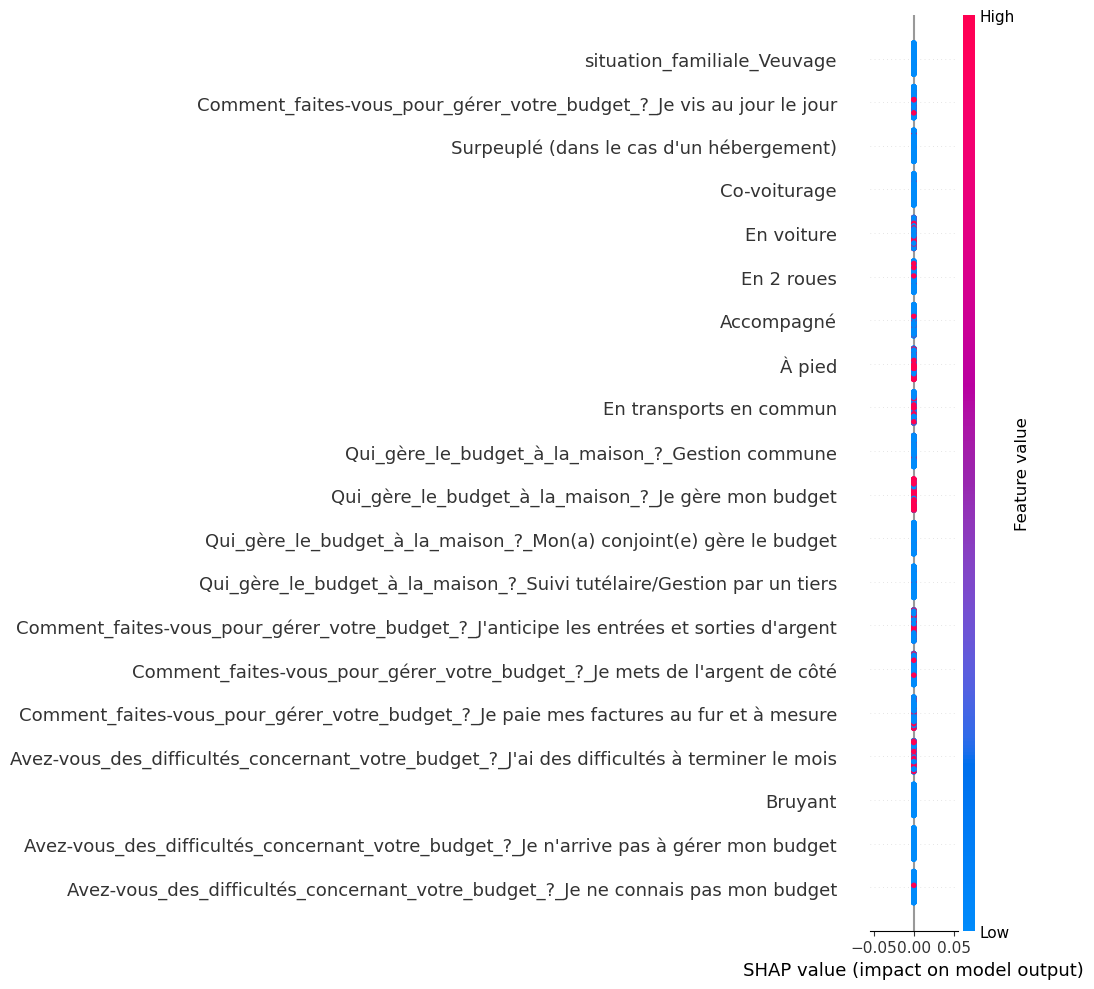

In [46]:
import shap
#X_dev_transformed = pipeline.named_steps['scaler'].transform(X_dev)
# Initialize your explainer
explainer = shap.Explainer(pipeline.named_steps['classifier'])

# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values[1], X_dev,plot_size=(10,10),show=False)


In [47]:
X_dev = X_dev*1

In [48]:
import numpy as np
import pandas as pd

# Calculer les statistiques descriptives de X_dev
stats_describe = X_dev.describe()

# Fonction pour calculer les pourcentages réels couverts
def calculate_real_percentage_or_value(min_val, max_val, feature, stats):
    if min_val == max_val:  # Si min et max sont égaux, retourner la valeur directement
        return str(min_val)
    else:
        total_range = stats.at['max', feature] - stats.at['min', feature]
        if total_range > 0:
            min_percentage = ((min_val - stats.at['min', feature]) / total_range) * 100
            max_percentage = ((max_val - stats.at['min', feature]) / total_range) * 100
            return f"{min_percentage:.2f}%-{max_percentage:.2f}%"
        else:
            return "N/A"
# Initialiser une liste globale pour collecter les données de toutes les classes
all_data = []

# Boucle sur toutes les classes disponibles dans `shap_values`
for classe in range(len(shap_values)):
    indices_of_class = [i for i, label in enumerate(y_dev) if label == classe]
    global_mean_abs_shap = np.mean(np.abs(shap_values[classe][indices_of_class, :]), axis=0).sum()
    data = []
    
    for i, feature_name in enumerate(X_dev.columns):
        positive_indices = [idx for idx in indices_of_class if shap_values[classe][idx, i] > 0]
        negative_indices = [idx for idx in indices_of_class if shap_values[classe][idx, i] < 0]
        original_values_positive = X_dev.iloc[positive_indices, i]
        original_values_negative = X_dev.iloc[negative_indices, i]
        mean_impact_positive = np.mean(np.abs(shap_values[classe][positive_indices, i])) if len(positive_indices) > 0 else 0
        mean_impact_negative = np.mean(np.abs(shap_values[classe][negative_indices, i])) if len(negative_indices) > 0 else 0
        normalized_impact_positive = (mean_impact_positive / global_mean_abs_shap) * 100 if global_mean_abs_shap > 0 else 0
        normalized_impact_negative = (mean_impact_negative / global_mean_abs_shap) * 100 if global_mean_abs_shap > 0 else 0
        positive_impact_percentage = len(positive_indices) / len(shap_values[classe][indices_of_class, i]) * 100
        
        # Gérer "Rule For" et "Rule Against" pour afficher une valeur unique si min == max
        rule_for = f"{original_values_positive.min()}" if original_values_positive.min() == original_values_positive.max() else f"{original_values_positive.min()} and < {original_values_positive.max()}"
        rule_against = f"{original_values_negative.min()}" if original_values_negative.min() == original_values_negative.max() else f"{original_values_negative.min()} and < {original_values_negative.max()}"
        
        data.append({
            'Class': classe,
            'Feature': feature_name,
            'Rule For': rule_for,
            'Rule Against': rule_against,
            'Couverture Pour': positive_impact_percentage,
            'Couverture Contre': 100-positive_impact_percentage,
            'Intervalle Pour': calculate_real_percentage_or_value(original_values_positive.min(), original_values_positive.max(), feature_name, stats_describe),
            'Intervalle Contre': calculate_real_percentage_or_value(original_values_negative.min(), original_values_negative.max(), feature_name, stats_describe),
            'Importance': round((np.abs(shap_values[classe][:, i]).mean() / np.sum(np.abs(shap_values[classe]).mean(axis=0))) * 100, 2)
        })
    
    all_data.extend(data)

# Créer le DataFrame final à partir de la liste globale
results_df = pd.DataFrame(all_data).sort_values('Importance', ascending=False).query('`Couverture Pour` > 0')
results_df.query('Class == 1 and `Rule For` != "N/A" and Importance > 1')



,Class,Feature,Rule For,Rule Against,Couverture Pour,Couverture Contre,Intervalle Pour,Intervalle Contre,Importance


In [49]:
results_df.query('Class == 0 and `Rule For` != "N/A" and Importance > 1')

,Class,Feature,Rule For,Rule Against,Couverture Pour,Couverture Contre,Intervalle Pour,Intervalle Contre,Importance
